In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
np.random.seed(23)

In [73]:
X, Y = make_classification(n_samples=10000, n_classes=2, n_informative=2, n_features=4)
X = X.reshape(X.shape[1], X.shape[0])
Y = Y.reshape(1, -1)
print(X.shape, Y.shape)
X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

(4, 10000) (1, 10000)


In [74]:
def initialize_parameters_deep(layers_dims):
    L = len(layers_dims)
    params = {}

    for l in range(1, L):
        params['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * np.sqrt(2/layers_dims[l]) # np.zeros((layers_dims[l], layers_dims[l - 1]))
        params['b' + str(l)] = np.zeros((layers_dims[l], 1))

    return params

In [75]:
layers_dims = [4, 4, 5, 2, 1]
params = initialize_parameters_deep(layers_dims)
for item in params.items():
    print(f'{item[0]} -- {item[1].shape}')

W1 -- (4, 4)
b1 -- (4, 1)
W2 -- (5, 4)
b2 -- (5, 1)
W3 -- (2, 5)
b3 -- (2, 1)
W4 -- (1, 2)
b4 -- (1, 1)


In [76]:
def linear_forward(A_prev, W, b):
    Z = np.dot(W, A_prev) + b

    cache = (A_prev, W, b)
    return Z, cache

In [77]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))

    return A, Z

In [78]:
def tanh(Z):
    A = np.tanh(Z)
    return A, Z

In [79]:
def relu(Z):
    A = np.maximum(0.0, Z)
    return A, Z

In [80]:
def linear_activation_forward(A_prev, W, b, activation, keep_prob=1):
    
    if activation == 'sigmoid':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation == 'relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    elif activation == 'tanh':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)

    D = np.random.rand(*A.shape)
    D = (D < keep_prob).astype(int)
    A = D * A
    A /= keep_prob

    activation_cache = (activation_cache, D)

    cache = (linear_cache, activation_cache)


    return A, cache


In [101]:
def L_model_forward(X, params, keep_prob=1):
    L = len(params) // 2
    caches = []
    A = X
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, params['W' + str(l)], params['b' + str(l)], 'relu', keep_prob)
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, params['W' + str(L)], params['b' + str(L)], 'sigmoid', keep_prob=1)
    caches.append(cache)
    return AL, caches

In [82]:
def compute_cost(Y, AL, eps=1e-12):
    m = AL.shape[1]

    cost = -1/m * np.sum(Y * np.log(AL + eps) + (1 - Y) * np.log(1 - AL + eps))

    return np.squeeze(cost)

In [83]:
def compute_cost_with_L2(Y, AL, params, lambd=0, eps=1e-12):
    m = AL.shape[1]

    regularization_cost = lambd / (2 * m)

    L = len(params) // 2

    sum_W = 0

    for l in range(1, L + 1):
        sum_W += np.sum(np.square(params['W' + str(l)]))

    regularization_cost *= np.squeeze(sum_W)

    print(regularization_cost)

    regular_cost = compute_cost(Y, AL, eps)

    cost = regular_cost + regularization_cost

    return cost

In [84]:
AL, caches = L_model_forward(X, params)
cost = compute_cost_with_L2(Y, AL, params, lambd=0.01)

print(cost)

1.3337646208831359e-05
0.8433312439128973


In [85]:
AL, caches = L_model_forward(X, params)
cost = compute_cost(Y, AL)
print(cost)

0.8433179062666885


In [86]:
def linear_backward(dZ, cache, lambd=0):

    A_prev, W, b = cache
    m = dZ.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T) + (lambd/m) * W
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db


In [87]:
def sigmoid_backward(dA, activation_cache):
    Z = activation_cache
    A = 1 / (1 + np.exp(-Z))
    return dA * A * (1 - A)

In [102]:
def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.multiply(dA, np.int64(Z > 0))

    return dZ

In [103]:
def tanh_backward(dA, activation_cache):
    Z = activation_cache

    return dA * (1 - np.square(np.tanh(Z)))

In [104]:
def linear_activation_backward(dA, cache, activation, lambd=0, keep_prob=1):
    linear_cache, activation_cache = cache
    activation_cache_without_D, D = activation_cache

    dA *= D
    dA /= keep_prob

    if activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache_without_D)
        dA_prev, dW, db = linear_backward(dZ, linear_cache, lambd)
    
    elif activation == 'relu':
        dZ = relu_backward(dA, activation_cache_without_D)
        dA_prev, dW, db = linear_backward(dZ, linear_cache, lambd)

    elif activation == 'tanh':
        dZ = tanh_backward(dA, activation_cache_without_D)
        dA_prev, dW, db = linear_backward(dZ, linear_cache, lambd)

    return dA_prev, dW, db

In [105]:
def L_model_backward(AL, Y, caches, lambd=0, keep_prob=1, eps=1e-12):
    dAL = -(np.divide(Y, AL + eps) - np.divide((1 - Y), (1 - AL + eps)))
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    L = len(caches)
    grads = {}
    dA_prev, dW, db = linear_activation_backward(dAL, caches[L - 1], 'sigmoid', lambd, keep_prob)
    grads['dW' + str(L)] = dW
    grads['db' + str(L)] = db
    grads['dA' + str(L - 1)] = dA_prev
    for l in reversed(range(L - 1)):
        dA_prev, dW, db = linear_activation_backward(dA_prev, caches[l], 'relu', lambd, keep_prob)
        grads['dW' + str(l + 1)] = dW
        grads['db' + str(l + 1)] = db
        grads['dA' + str(l)] = dA_prev

    return grads


In [106]:
grads = L_model_backward(AL, Y, caches)
grads

{'dW4': array([[0.2516374 , 0.58707088]]),
 'db4': array([[0.16597528]]),
 'dA3': array([[-0.03486038, -0.0235851 , -0.0936943 , ..., -0.09637514,
         -0.10072822,  0.10610832],
        [-0.0607458 , -0.04109811, -0.16326659, ..., -0.16793808,
         -0.17552353,  0.18489859]]),
 'dW3': array([[2.63234529e-02, 2.40805969e-02, 1.57942880e-06, 4.50478549e-02,
         9.84485652e-03],
        [3.07671066e-02, 3.56680463e-02, 2.75222679e-06, 7.79827498e-02,
         6.95165091e-03]]),
 'db3': array([[0.03367854],
        [0.05228431]]),
 'dA2': array([[ 0.06792493,  0.04595521,  0.01214745, ...,  0.01249503,
          0.        , -0.01375693],
        [-0.07513894, -0.05083591,  0.02482159, ...,  0.02553181,
          0.        , -0.02811033],
        [-0.03881822, -0.02626281, -0.01160568, ..., -0.01193775,
          0.        ,  0.01314338],
        [-0.18471807, -0.12497263, -0.10165626, ..., -0.10456492,
          0.        ,  0.1151252 ],
        [-0.04183199, -0.0283018 , -0.

In [107]:
def update_parameters(params, grads, learning_rate=0.01):
    L = len(params) // 2

    for l in range(1, L + 1):
        params['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        params['b' + str(l)] -= learning_rate * grads['db' + str(l)]

    return params

In [108]:
def L_layer_model(X, Y, params, lambd=0, keep_prob=1, learning_rate=0.01, num_iterations=1000, print_cost=False): 
    costs = []
    for i in range(num_iterations):
        AL, caches = L_model_forward(X, params, keep_prob)
        cost = compute_cost(Y, AL)
        grads = L_model_backward(AL, Y, caches, lambd, keep_prob)
        params = update_parameters(params, grads, learning_rate)

        if print_cost and (i % 100 == 0 or i == num_iterations - 1):
            print(f"Cost after iteration {i}: {np.squeeze(cost)}")
        if i % 100 == 0:
            costs.append(cost)

    return params, costs

Cost after iteration 0: 0.6931471805579453
Cost after iteration 100: 0.6931468640368527
Cost after iteration 200: 0.6931467478869455
Cost after iteration 300: 0.6931467052648123
Cost after iteration 400: 0.6931466896242777
Cost after iteration 500: 0.6931466838848569
Cost after iteration 600: 0.6931466817787301
Cost after iteration 700: 0.6931466810058695
Cost after iteration 800: 0.693146680722262
Cost after iteration 900: 0.69314668061819
Cost after iteration 999: 0.6931466805802229


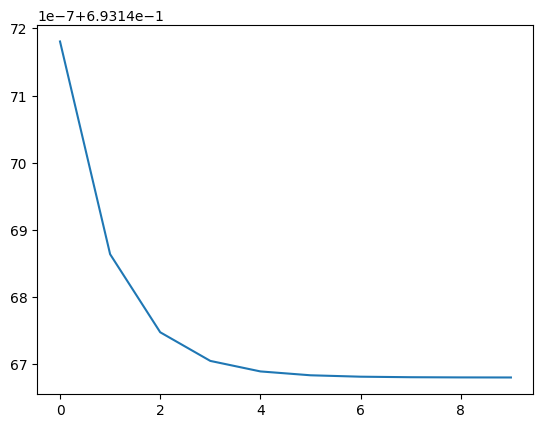

In [109]:
def initialize_with_zeros(layer_dims):
    params = {}
    L = len(layer_dims)
    for l in range(1, L):
        params['W' + str(l)] = np.zeros((layer_dims[l], layer_dims[l - 1]))
        params['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return params

params = initialize_with_zeros(layers_dims)
params, costs = L_layer_model(X, Y, params, keep_prob=0.5, print_cost=True)
plt.plot(range(len(costs)), costs)
plt.show()

Cost after iteration 0: 0.7180580268779119
Cost after iteration 100: 0.7002858563431029
Cost after iteration 200: 0.6965919176311434
Cost after iteration 300: 0.6954458798692787
Cost after iteration 400: 0.6948424888855319
Cost after iteration 500: 0.6945009503302365
Cost after iteration 600: 0.6942860186594372
Cost after iteration 700: 0.6941606011273073
Cost after iteration 800: 0.6940597796786305
Cost after iteration 900: 0.6939864081990123
Cost after iteration 999: 0.6939327328173177


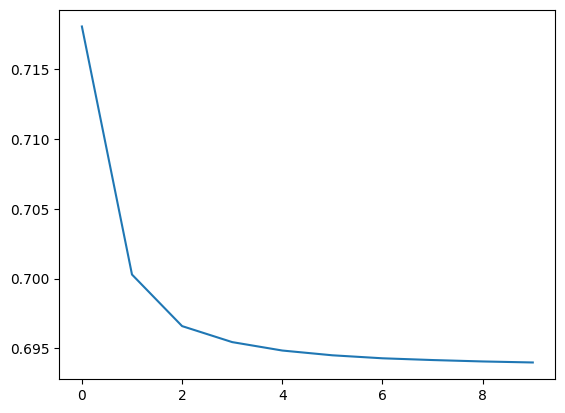

In [110]:
params = initialize_parameters_deep(layers_dims)
params, costs = L_layer_model(X, Y, params, lambd=0.1, print_cost=True)
plt.plot(range(len(costs)), costs)
plt.show()

Cost after iteration 0: 1.1352278707296168
Cost after iteration 100: 0.6958449741218755
Cost after iteration 200: 0.693624028867363
Cost after iteration 300: 0.69334963666299
Cost after iteration 400: 0.6932227707732166
Cost after iteration 500: 0.6931418531091289
Cost after iteration 600: 0.6930919451630455
Cost after iteration 700: 0.6930586946180138
Cost after iteration 800: 0.6930369395253323
Cost after iteration 900: 0.6930240679925012
Cost after iteration 999: 0.6930159985842649


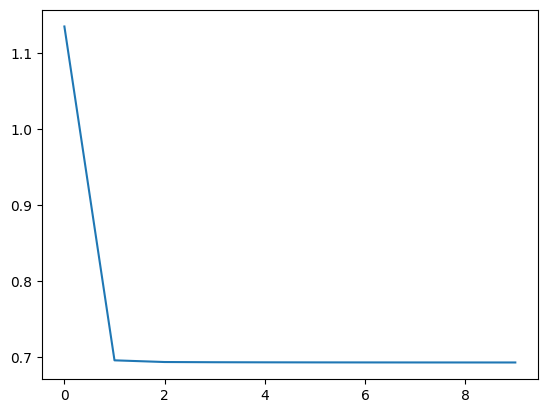

In [111]:
def He_initialization(layer_dims):
    params = {}
    L = len(layer_dims)
    for l in range(1, L):
        params['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * np.sqrt(2/ layer_dims[l - 1])
        params['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return params

params = He_initialization(layers_dims)
params, costs = L_layer_model(X, Y, params, lambd=0.01, print_cost=True)
plt.plot(range(len(costs)), costs)
plt.show()

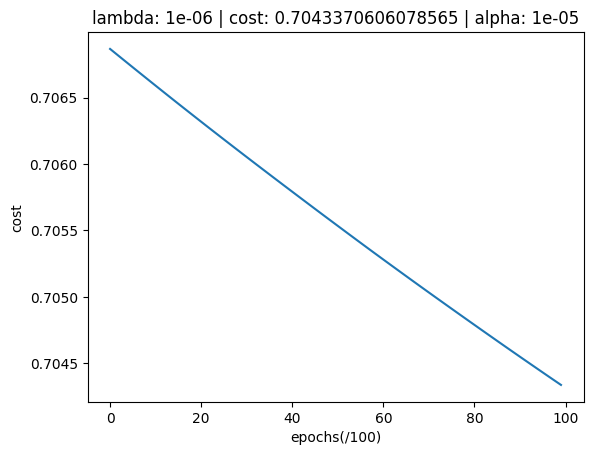

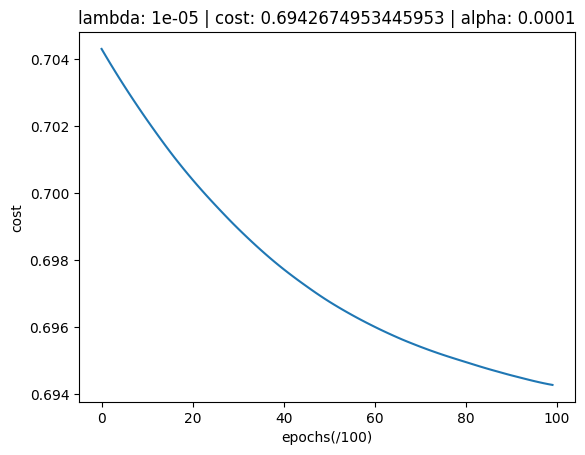

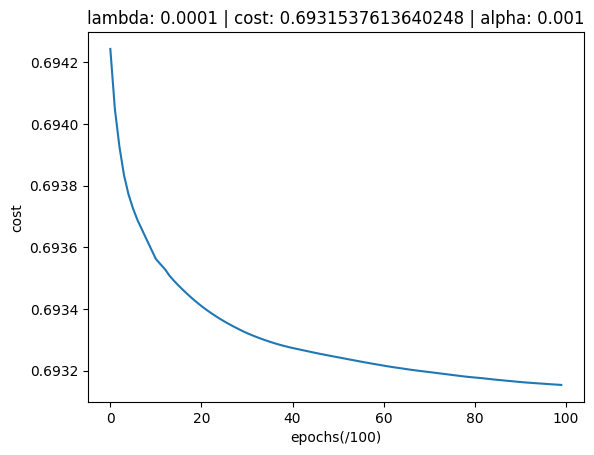

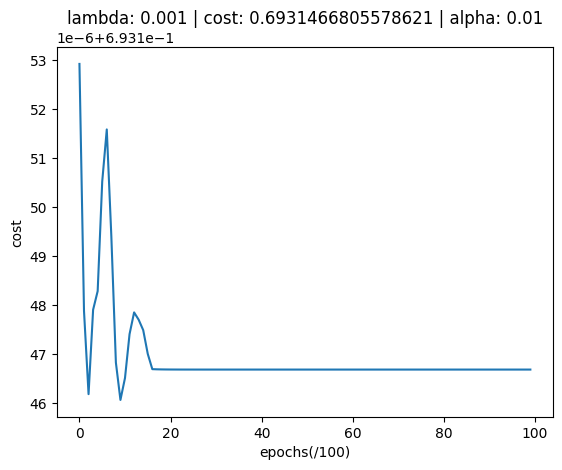

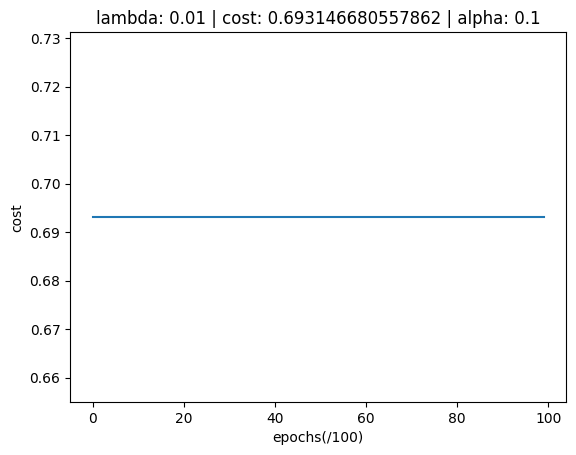

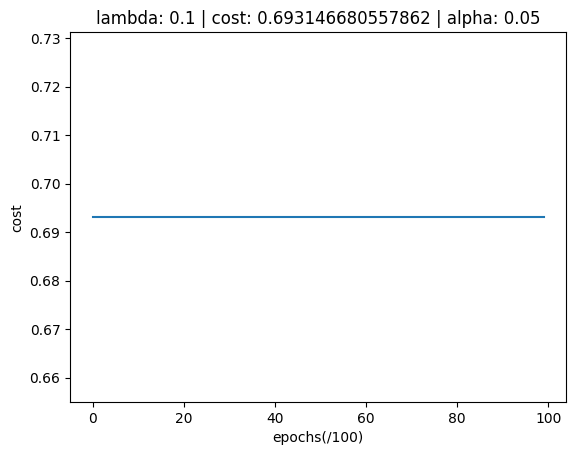

In [100]:
lambds = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.05]
params = He_initialization(layers_dims)

test = list(zip(lambds, alphas))

for lambd, alpha in list(zip(lambds, alphas)):
    params, costs = L_layer_model(X, Y, params, lambd=lambd, learning_rate=alpha, num_iterations=1000)
    plt.plot(range(len(costs)), costs)
    plt.title(f'lambda: {lambd} | cost: {costs[-1]} | alpha: {alpha}')
    plt.xlabel('epochs(/100)')
    plt.ylabel('cost')
    plt.show()